### Install/import packaages

In [ ]:
%pip install -q openpyxl
%pip install -q tensorflow --upgrade
%pip install -q keras
%pip install -q keras.utils

In [18]:
import pandas as pd
pd.set_option('display.max_colwidth', 160)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

from keras import Sequential
from keras.api.layers import Dense
from keras.api.utils import to_categorical

### Load Data in Dataframe

In [19]:
# Load the dataset
df = pd.read_excel('dataset.xlsx')

# Display the dataset to understand its structure and the extent of missing data
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  925 non-null    int64  
 1   var1    925 non-null    float64
 2   var2    925 non-null    float64
 3   var3    925 non-null    object 
 4   var4    325 non-null    float64
 5   var5    925 non-null    float64
 6   var6    925 non-null    object 
 7   var7    925 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 57.9+ KB
None
target      0
var1        0
var2        0
var3        0
var4      600
var5        0
var6        0
var7        0
dtype: int64


### Data Preprocessing

#### var7 data fixes

In [20]:
# Convert datetime to numeric (timestamp)
df['var7'] = pd.to_datetime(df['var7'], errors='coerce')
df['var7'] = df['var7'].astype('int64') / 10**9  # Convert to seconds since epoch

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  925 non-null    int64  
 1   var1    925 non-null    float64
 2   var2    925 non-null    float64
 3   var3    925 non-null    object 
 4   var4    325 non-null    float64
 5   var5    925 non-null    float64
 6   var6    925 non-null    object 
 7   var7    925 non-null    float64
dtypes: float64(5), int64(1), object(2)
memory usage: 57.9+ KB


#### var4 prediction using K-NN

KNN imputer calculates the mean or median of the nearest neighbors for each missing value in a feature column and uses this calculated value as the imputation.

In [21]:
# Encode categorical variables
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Scale the data before imputing
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Use KNNImputer to fill missing values in var4
imputer = KNNImputer(n_neighbors=5)
df.iloc[:, :] = imputer.fit_transform(df)

In [22]:
# Display the dataset to understand its structure and the extent of missing data
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  925 non-null    int64  
 1   var1    925 non-null    float64
 2   var2    925 non-null    float64
 3   var3    925 non-null    int32  
 4   var4    925 non-null    float64
 5   var5    925 non-null    float64
 6   var6    925 non-null    int32  
 7   var7    925 non-null    float64
dtypes: float64(5), int32(2), int64(1)
memory usage: 50.7 KB
None
target    0
var1      0
var2      0
var3      0
var4      0
var5      0
var6      0
var7      0
dtype: int64


##### Now there are no missing values in all columns

### Prepare the data for classification models

In [23]:
# Split the data into features and target
X = df.drop('target', axis=1)
y = df['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Classifiers

#### Random Forests

In [24]:
# Train a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy of Random Forests: {accuracy}")
print("Classification Report:")
print(class_report)

Accuracy of Random Forests: 0.9621621621621622
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96        97
           1       0.96      0.97      0.96        88

    accuracy                           0.96       185
   macro avg       0.96      0.96      0.96       185
weighted avg       0.96      0.96      0.96       185



#### Interpretation:

96.22% of total predictions by the model are correct.

The Random Forest model shows strong and balanced performance in precision, recall, and F1-scores for both classes. This indicates it's effective and reliable for binary classification.

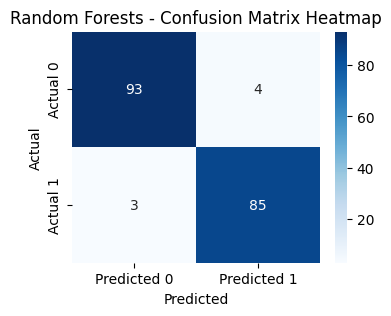

In [25]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forests - Confusion Matrix Heatmap')
plt.show()

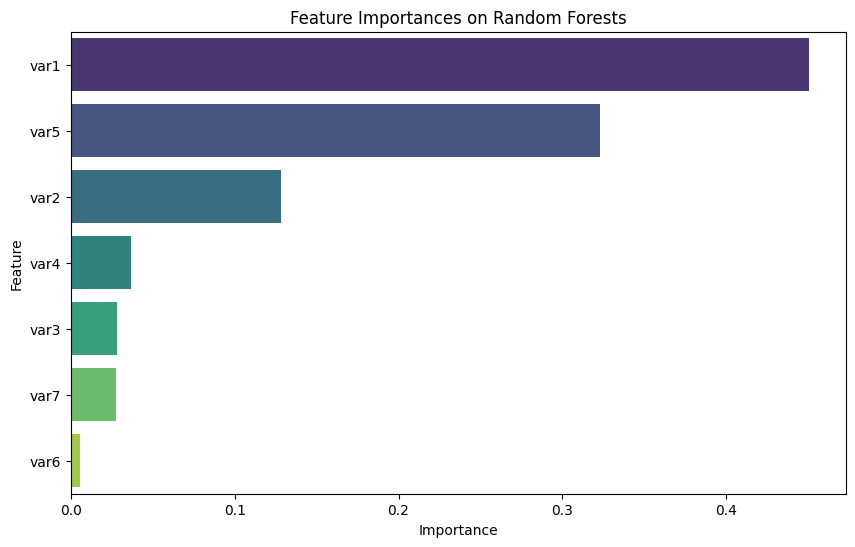

In [26]:
# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, hue='Feature', dodge=False, palette='viridis')
plt.title('Feature Importances on Random Forests')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

#### Interpretation:

var1, var5, and var2 are the important features

#### Logistic Regression

In [27]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a Logistic Regression Classifier
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = log_reg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy of Logistic Regression: {accuracy}")
print("Classification Report:")
print(class_report)


Accuracy of Logistic Regression: 0.9513513513513514
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95        97
           1       0.94      0.95      0.95        88

    accuracy                           0.95       185
   macro avg       0.95      0.95      0.95       185
weighted avg       0.95      0.95      0.95       185



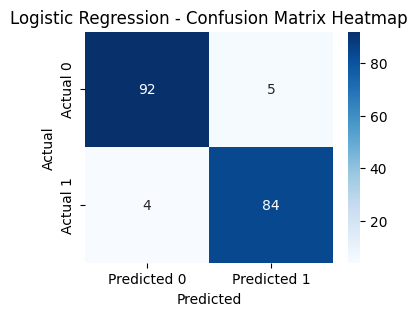

In [28]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression - Confusion Matrix Heatmap')
plt.show()

#### Decision Trees

In [29]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = dt_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy of Decision Trees: {accuracy}")
print("Classification Report:")
print(class_report)

Accuracy of Decision Trees: 0.9405405405405406
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94        97
           1       0.93      0.94      0.94        88

    accuracy                           0.94       185
   macro avg       0.94      0.94      0.94       185
weighted avg       0.94      0.94      0.94       185



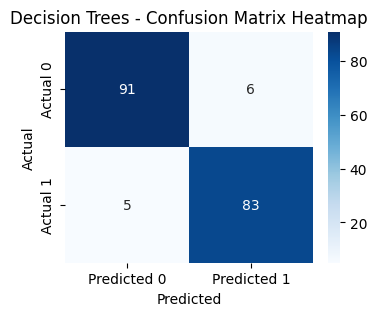

In [30]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Trees - Confusion Matrix Heatmap')
plt.show()

#### ANN

In [31]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert target variable to categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Build the neural network
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=10, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
y_pred = np.argmax(model.predict(X_test), axis=1)
y_test_class = np.argmax(y_test, axis=1)

class_report = classification_report(y_test_class, y_pred)

print(f"Accuracy of ANN: {accuracy}")
print("Classification Report:")
print(class_report)

Epoch 1/50


C:\Users\HENNY PURWADI\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8519 - loss: 0.4605  
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9590 - loss: 0.1408
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9586 - loss: 0.1224  
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9679 - loss: 0.1041
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9506 - loss: 0.1328
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9663 - loss: 0.1077
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9668 - loss: 0.0989
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9663 - loss: 0.1057
Epoch 9/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9580 - loss: 0.1176
Epoch 10/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9619 - loss: 0.1007
Epoch 11/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9650 - loss: 0.0886
Epoch 12/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9684 - loss: 0.0

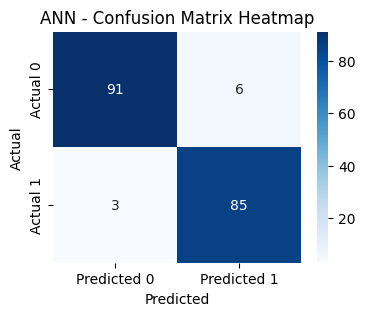

In [32]:
# Confusion matrix
cm = confusion_matrix(y_test_class, y_pred)

# Plot the heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('ANN - Confusion Matrix Heatmap')
plt.show()

#### Accuracy

| Classifier                                                    | Accuracy              |
| ------------------------------------------------------------- | --------------------: |
| Accuracy of Random Forests                                    | 0.9621621621621622    |
| Accuracy of Logistic Regression	                            | 0.9513513513513514    |
| Accuracy of Decision Trees	                                | 0.9405405405405406    |
| Accuracy of ANN			                                    | 0.9513513445854187    |

We will use Random Forests as our classifier to fine-tune.


#### Fine Tune Random Forest

In [34]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4],
    'bootstrap': [True, False]
}

#Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator = rf_classifier, param_grid = param_grid,
                           cv = 5, n_jobs = -1, verbose = 2, scoring = 'accuracy')

grid_search.fit(X_train, y_train)

#Evaluate the best model
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

print("Best Parameters:", grid_search.best_params_)
print("Accuracy on Test Set: ", accuracy_score(y_test, y_pred))
print("Classification Report: ", classification_report(y_test, y_pred))

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy on Test Set:  0.9621621621621622
Classification Report:                precision    recall  f1-score   support

           0       0.97      0.96      0.96        97
           1       0.96      0.97      0.96        88

   micro avg       0.96      0.96      0.96       185
   macro avg       0.96      0.96      0.96       185
weighted avg       0.96      0.96      0.96       185
 samples avg       0.96      0.96      0.96       185



#### Random Forest's Best Parameters: 
                {
                'bootstrap': False, 
                'max_depth': None, 
                'max_features': 'sqrt', 
                'min_samples_leaf': 1, 
                'min_samples_split': 10, 
                'n_estimators': 200
                }